In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import seaborn as sns
from dataloader import DataLoader
from PIL import Image
from _graphutils import GraphUtils
from _plotutils import PlotUtils
from kernels.wlkernel import WLKernel
from kernels.shortestpathkernel import ShortestPathKernel
from kernels.randomwalkkernel import RandomWalkKernel
from kernels.labelhasher import LabelHasher
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import LeaveOneOut
import networkx as nx

In [ ]:
dl = DataLoader("../eyelink_data")
imgs = dl.get_example_images()

PLOT = {
    "aois": False,
    "scanpaths": False,
    "clustering": False,
    "matrices": False,
    "graphs": False,
    "kernel": False,
    "tsne": False,
    "mds": True,
    "loocv": True,
    "entropy": False
}

sima diameter 1: 3
sima diameter 2: 3
weak diameter 1: 3
weak diameter 2: 3


sima diameter 1: 3
sima diameter 2: 2
weak diameter 1: 3
weak diameter 2: 1


sima diameter 1: 3
sima diameter 2: 2
weak diameter 1: 3
weak diameter 2: 2


sima diameter 1: 3
sima diameter 2: 3
weak diameter 1: 3
weak diameter 2: 2


sima diameter 1: 3
sima diameter 2: 3
weak diameter 1: 3
weak diameter 2: 2


sima diameter 1: 3
sima diameter 2: 2
weak diameter 1: 3
weak diameter 2: 1


sima diameter 1: 3
sima diameter 2: 2
weak diameter 1: 3
weak diameter 2: 2


sima diameter 1: 3
sima diameter 2: 4
weak diameter 1: 3
weak diameter 2: 3


sima diameter 1: 3
sima diameter 2: 2
weak diameter 1: 3
weak diameter 2: 2


sima diameter 1: 3
sima diameter 2: 3
weak diameter 1: 3
weak diameter 2: 2


sima diameter 1: 3
sima diameter 2: 3
weak diameter 1: 3
weak diameter 2: 2


not stronly connected
sima diameter 1: 3
sima diameter 2: 2
weak diameter 1: 3
weak diameter 2: 2


sima diameter 1: 3
sima diameter 2: 2
weak

[Text(0, 0, '2017_28690375'),
 Text(1, 0, '2017_44808194'),
 Text(2, 0, '2017_98830509')]

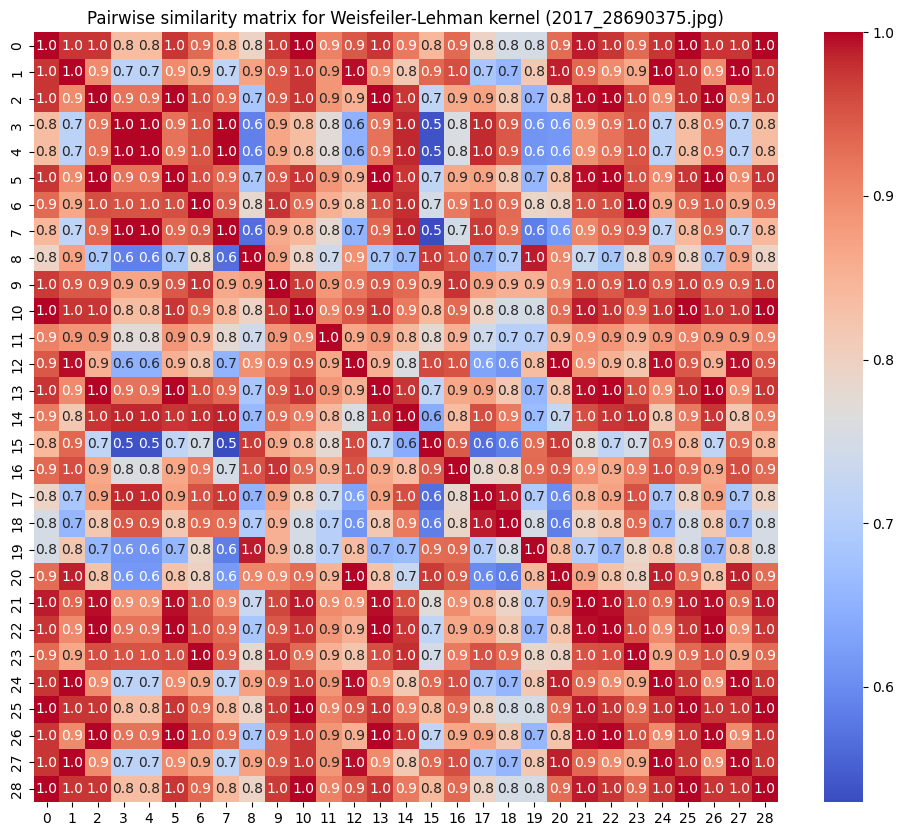

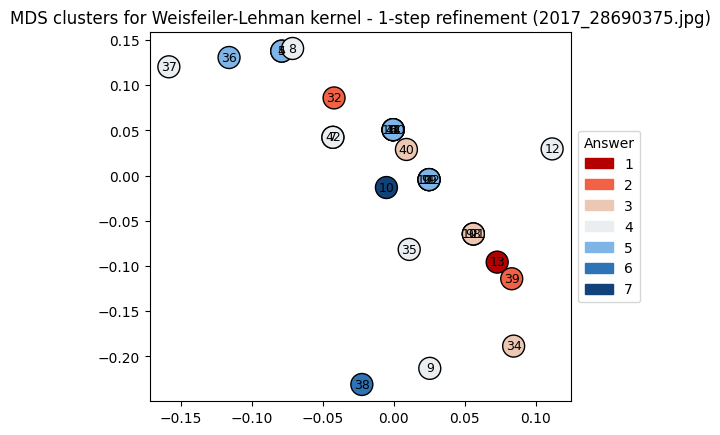

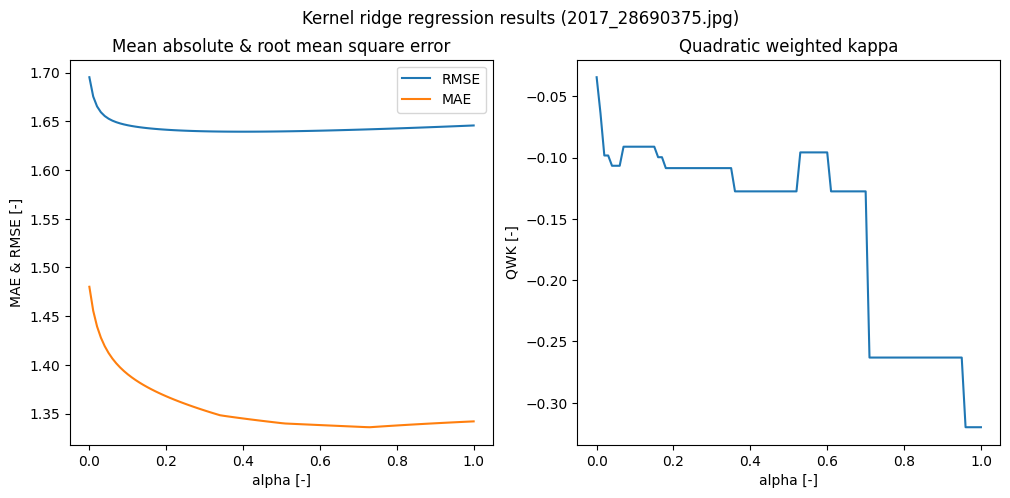

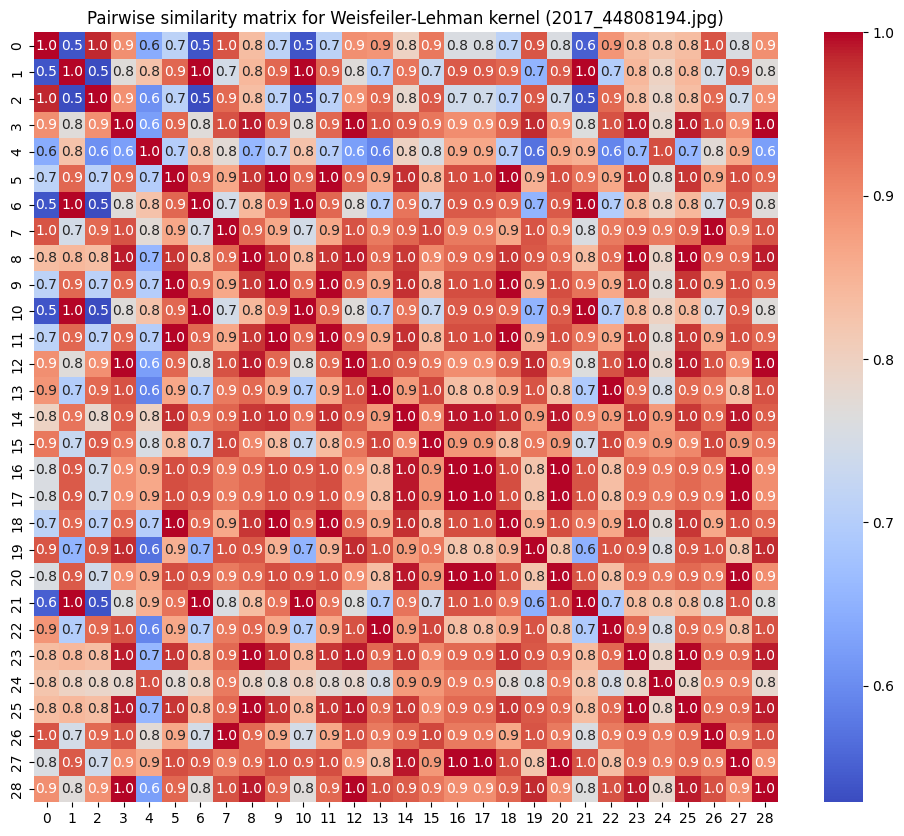

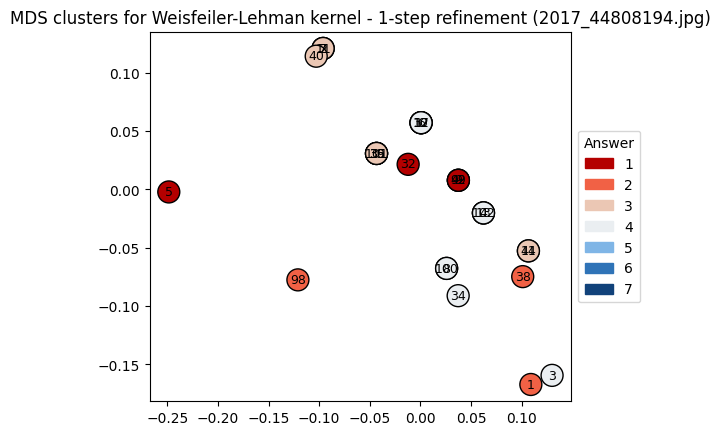

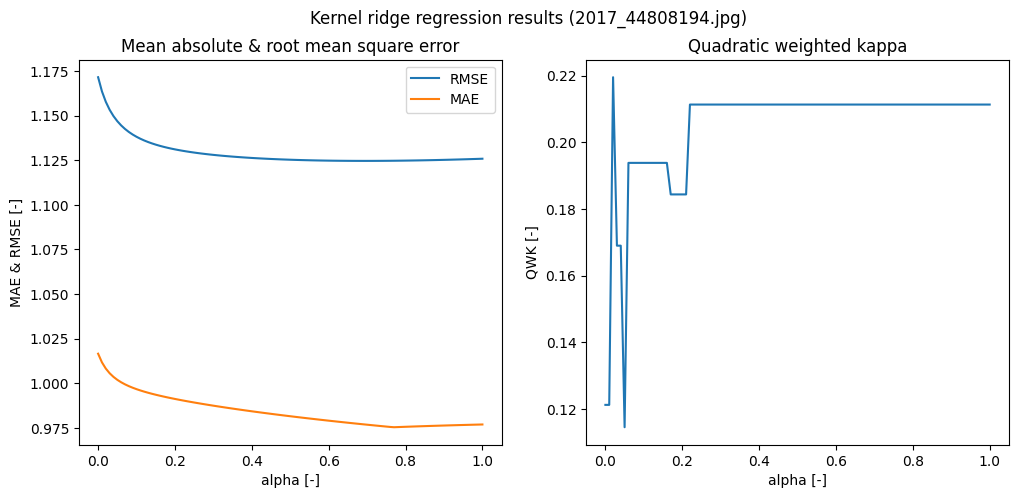

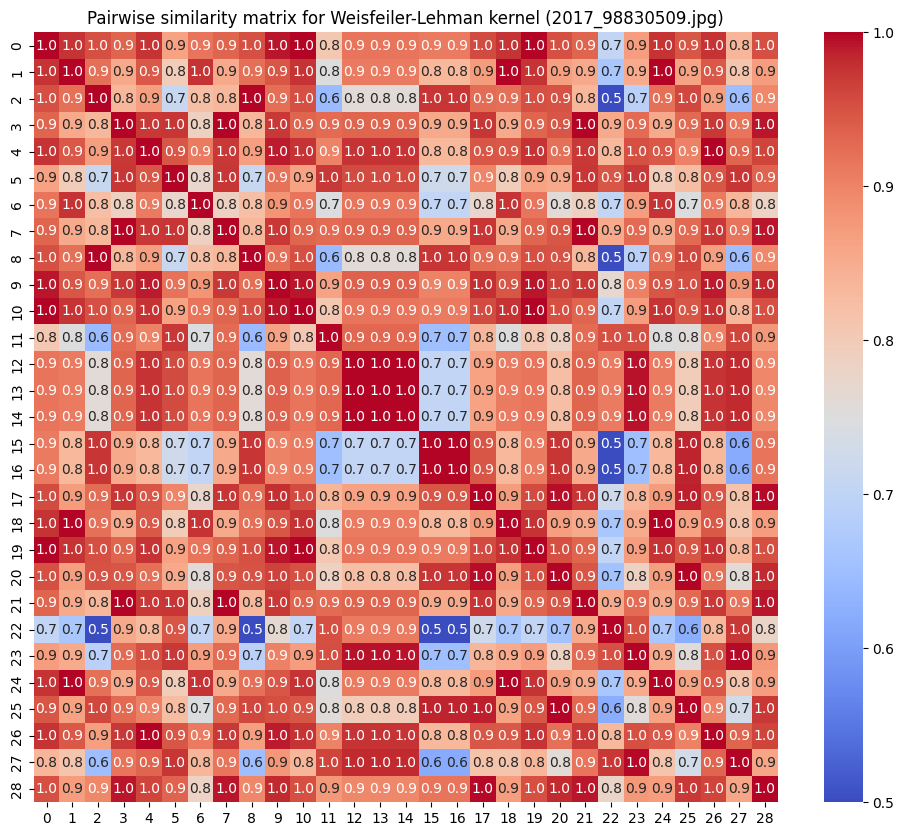

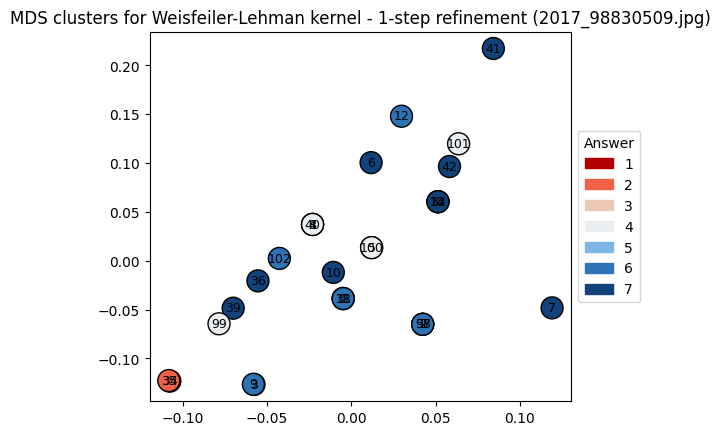

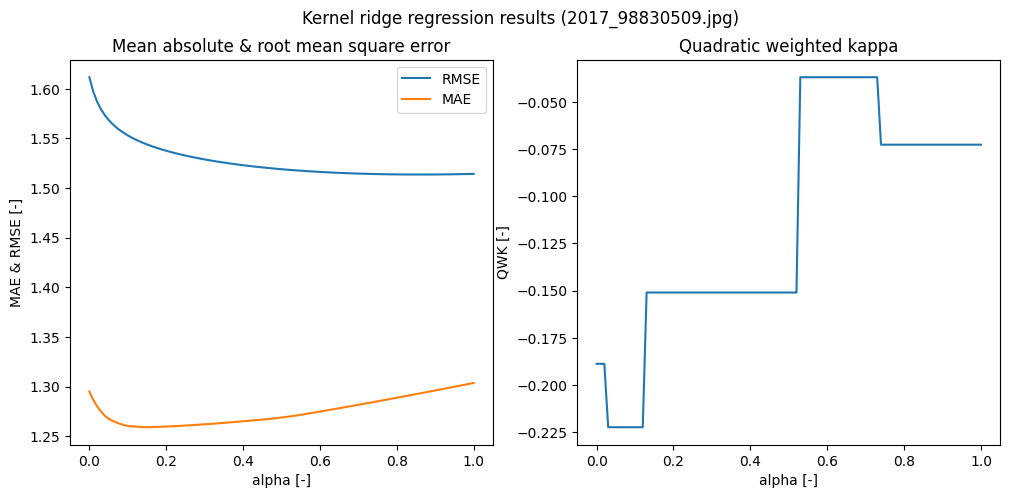

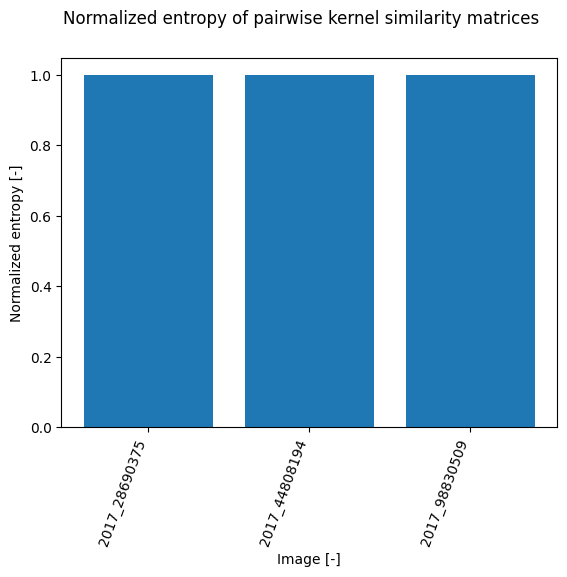

In [10]:
K_entropies = {}

for img in imgs:
    img_file = dl.get_image(img)
    aois = dl.get_image_aois(img)

    if PLOT["aois"]:
        PlotUtils.plot_aois(aois=aois, title="Original image and predefined AOIs", image=img_file)


    trials = dl.get_image_trials(img)
    trial_numbers = dl.get_image_trials(img, False)
    answer_dfs = dl.get_image_answers(img)
    answers = dl.get_image_ratings(img) 
    if PLOT["scanpaths"]:
        PlotUtils.wrap_dict_plot(trials, n_wrap=3, plotting_function=PlotUtils.trace_plot, title="Subject", image=img_file)



    MIN_CLUSTERS = 2
    MAX_CLUSTERS = 10

    trials_clustered: dict[int, pd.DataFrame] = {}
    cluster_centers: dict[int, dict[int, tuple[float, float]]] = {}
    for (subject, trial) in trials.items():
        df_clustered, intertia, cluster_c, k = GraphUtils.optimal_clustering(MIN_CLUSTERS, MAX_CLUSTERS, trial)
        trials_clustered[subject] = df_clustered
        cluster_centers[subject] = cluster_c

    if PLOT["clustering"]:
        PlotUtils.wrap_dict_plot(trials_clustered, n_wrap=3, plotting_function=PlotUtils.clustering_plot, title="Subject", image=img_file)


    # TRANSITION MATRCIES
    matrices = {subject: GraphUtils.transition_matrix(trial) for (subject, trial) in trials_clustered.items()}
    if PLOT["matrices"]:
        PlotUtils.wrap_dict_plot(matrices, n_wrap=3, plotting_function=PlotUtils.heatmap, title="Subject")



    # GRAPHS
    graphs = {subject: GraphUtils.transition_matrix_to_graph(matrix) for (subject, matrix) in matrices.items()}
    if PLOT["graphs"]:
        PlotUtils.wrap_dict_plot(graphs, n_wrap=3, plotting_function=PlotUtils.draw, title="Subject")



    # PRECOMPUTED KERNEL MATRIX
    for refining_step in range(1, 2):
        subjects_order = list(matrices.keys())
        K_matrix = np.zeros(shape=(len(matrices), len(matrices)))
        for i, (subject1, G1) in enumerate(graphs.items()):
            for j, (subject2, G2) in enumerate(graphs.items()):
                if (nx.is_strongly_connected(G1) and nx.is_strongly_connected(G2)):
                    print(f"sima diameter 1: {nx.diameter(G1)}")
                    print(f"sima diameter 2: {nx.diameter(G2)}")
                    print(f"weak diameter 1: {nx.diameter(G1.to_undirected())}")
                    print(f"weak diameter 2: {nx.diameter(G2.to_undirected())}")
                    print("\n")
                else:
                    print("not stronly connected")
                wl = WLKernel(hasher=LabelHasher())
                steps = 3
                v1 = wl.get_feature_vector(G1, refinement_steps=refining_step)
                v2 = wl.get_feature_vector(G2, refinement_steps=refining_step)
                K_matrix[i][j] = wl.get_kernel_value(v1, v2)

        if PLOT["kernel"]:
            PlotUtils.heatmap(K_matrix, title=f"Pairwise similarity matrix for Weisfeiler-Lehman kernel ({img})")


        D_matrix = 1 - K_matrix

        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        X_2d_mds = mds.fit_transform(D_matrix)

        tsne = TSNE(n_components=2, perplexity=20, metric='precomputed', init="random", random_state=42)
        X_2d_tsne = tsne.fit_transform(D_matrix)

        labels = np.array(list(answers.values()))

        if PLOT["tsne"]:
            PlotUtils.dimensionality_reduction_plot(X_2d_tsne, title=f"t-SNE clusters for Weisfeiler-Lehman kernel - {refining_step}-step refinement ({img})", annotate=True, labels=answers)
        
        if PLOT["mds"]:
            PlotUtils.dimensionality_reduction_plot(X_2d_mds, title=f"MDS clusters for Weisfeiler-Lehman kernel - {refining_step}-step refinement ({img})", annotate=True, labels=answers)


        # LEAVE ONE OUT CROSS VALIDATION
        results = GraphUtils.loocv(K_matrix, answers)
        if PLOT["loocv"]:
            PlotUtils.loocv_plot(results, f"Kernel ridge regression results ({img})")
        
        K_entropy = GraphUtils.kernel_entropy(K_matrix)
        K_entropies[img] = K_entropy

fig, ax = plt.subplots(1, 1)
fig.suptitle(f"Normalized entropy of pairwise kernel similarity matrices")
ax.bar(x=[str(key) for key in K_entropies.keys()], height=K_entropies.values())
ax.set(xlabel="Image [-]", ylabel="Normalized entropy [-]")
ax.set_xticks(range(len(imgs)))           
ax.set_xticklabels([str(key)[0:-4] for key in K_entropies.keys()], rotation=70, ha='right')  